# =============================================================
# MILESTONE 3: Machine Learning Model Development and Optimization
# =============================================================

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (train_test_split, cross_val_score, 
                                      StratifiedKFold, GridSearchCV, RandomizedSearchCV)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, roc_auc_score, confusion_matrix, 
                            classification_report, roc_curve, auc)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')

# =============================================================
#  DATA LOADING AND PREPARATION
# =============================================================

In [80]:
url = "../data/processed/processed_data.csv"
df = pd.read_csv(url)

df.shape

(3333, 16)

In [81]:
X = df.drop("Churn", axis=1)
y = df["Churn"]

# Train/test split (80/20) with stratification

In [82]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Before SMOTE:", np.bincount(y_train))

Before SMOTE: [2280  386]



# Apply SMOTE only to training set

In [83]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("After SMOTE:", np.bincount(y_train_resampled))

After SMOTE: [2280 2280]


# =============================================================
#  MODEL SELECTION AND INITIALIZATION
# =============================================================

In [84]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
}

print(f"\nModels initialized: {list(models.keys())}")


Models initialized: ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost']


# =============================================================
# TRAINING MODELS ON FULL TRAINING SET
# =============================================================

In [85]:
print("\n" + "="*70)
print("TRAINING MODELS ON FULL TRAINING SET")
print("="*70)

trained_models = {}
train_predictions = {}
test_predictions = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_resampled, y_train_resampled)
    trained_models[name] = model
    
    # Training set predictions (for overfitting detection)
    y_train_pred = model.predict(X_train_resampled)
    y_train_prob = model.predict_proba(X_train_resampled)[:, 1]
    
    train_predictions[name] = {
        'y_pred': y_train_pred,
        'y_prob': y_train_prob
    }
    
    # Test set predictions
    y_test_pred = model.predict(X_test)
    y_test_prob = model.predict_proba(X_test)[:, 1]
    
    test_predictions[name] = {
        'y_pred': y_test_pred,
        'y_prob': y_test_prob
    }


TRAINING MODELS ON FULL TRAINING SET

Training Logistic Regression...

Training Decision Tree...

Training Random Forest...

Training Gradient Boosting...

Training XGBoost...


# =============================================================
# MODEL EVALUATION ON TEST SET
# =============================================================

In [86]:
print("\n" + "="*70)
print("TEST SET EVALUATION")
print("="*70)

test_results = []

for name in models.keys():
    y_pred = test_predictions[name]['y_pred']
    y_prob = test_predictions[name]['y_prob']
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    test_results.append({
        'Model': name,
        'Test_Accuracy': accuracy,
        'Test_Precision': precision,
        'Test_Recall': recall,
        'Test_F1': f1,
        'Test_ROC_AUC': roc_auc
    })
    
    print(f"\n{name}:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  ROC-AUC:   {roc_auc:.4f}")

test_results_df = pd.DataFrame(test_results)


TEST SET EVALUATION

Logistic Regression:
  Accuracy:  0.8576
  Precision: 0.5062
  Recall:    0.8454
  F1-Score:  0.6332
  ROC-AUC:   0.8692

Decision Tree:
  Accuracy:  0.8921
  Precision: 0.5940
  Recall:    0.8144
  F1-Score:  0.6870
  ROC-AUC:   0.8598

Random Forest:
  Accuracy:  0.9490
  Precision: 0.8621
  Recall:    0.7732
  F1-Score:  0.8152
  ROC-AUC:   0.9258

Gradient Boosting:
  Accuracy:  0.9475
  Precision: 0.8100
  Recall:    0.8351
  F1-Score:  0.8223
  ROC-AUC:   0.9265

XGBoost:
  Accuracy:  0.9550
  Precision: 0.8764
  Recall:    0.8041
  F1-Score:  0.8387
  ROC-AUC:   0.9172


# =============================================================
# OVERFITTING DETECTION
# =============================================================

In [87]:
print("\n" + "="*70)
print("OVERFITTING ANALYSIS (Train vs Test Performance)")
print("="*70)

overfitting_analysis = []

for name in models.keys():
    # Training metrics
    y_train_pred = train_predictions[name]['y_pred']
    y_train_prob = train_predictions[name]['y_prob']
    train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
    train_roc_auc = roc_auc_score(y_train_resampled, y_train_prob)
    train_f1 = f1_score(y_train_resampled, y_train_pred)
    
    # Test metrics
    test_row = test_results_df[test_results_df['Model'] == name].iloc[0]
    test_accuracy = test_row['Test_Accuracy']
    test_roc_auc = test_row['Test_ROC_AUC']
    test_f1 = test_row['Test_F1']
    
    # Calculate gaps
    accuracy_gap = train_accuracy - test_accuracy
    roc_auc_gap = train_roc_auc - test_roc_auc
    f1_gap = train_f1 - test_f1
    
    overfitting_analysis.append({
        'Model': name,
        'Train_Accuracy': train_accuracy,
        'Test_Accuracy': test_accuracy,
        'Accuracy_Gap': accuracy_gap,
        'Train_ROC_AUC': train_roc_auc,
        'Test_ROC_AUC': test_roc_auc,
        'ROC_AUC_Gap': roc_auc_gap,
        'Train_F1': train_f1,
        'Test_F1': test_f1,
        'F1_Gap': f1_gap,
        'Overfitting_Risk': 'High' if (accuracy_gap > 0.1 or roc_auc_gap > 0.1) else 
                           'Moderate' if (accuracy_gap > 0.05 or roc_auc_gap > 0.05) else 'Low'
    })
    
    print(f"\n{name}:")
    print(f"  Train Accuracy: {train_accuracy:.4f} | Test Accuracy: {test_accuracy:.4f} | Gap: {accuracy_gap:.4f}")
    print(f"  Train ROC-AUC:  {train_roc_auc:.4f} | Test ROC-AUC:  {test_roc_auc:.4f} | Gap: {roc_auc_gap:.4f}")
    print(f"  Train F1-Score: {train_f1:.4f} | Test F1-Score: {test_f1:.4f} | Gap: {f1_gap:.4f}")
    print(f"  Overfitting Risk: {overfitting_analysis[-1]['Overfitting_Risk']}")

overfitting_df = pd.DataFrame(overfitting_analysis)


OVERFITTING ANALYSIS (Train vs Test Performance)

Logistic Regression:
  Train Accuracy: 0.8632 | Test Accuracy: 0.8576 | Gap: 0.0056
  Train ROC-AUC:  0.8920 | Test ROC-AUC:  0.8692 | Gap: 0.0228
  Train F1-Score: 0.8642 | Test F1-Score: 0.6332 | Gap: 0.2310
  Overfitting Risk: Low

Decision Tree:
  Train Accuracy: 1.0000 | Test Accuracy: 0.8921 | Gap: 0.1079
  Train ROC-AUC:  1.0000 | Test ROC-AUC:  0.8598 | Gap: 0.1402
  Train F1-Score: 1.0000 | Test F1-Score: 0.6870 | Gap: 0.3130
  Overfitting Risk: High

Random Forest:
  Train Accuracy: 1.0000 | Test Accuracy: 0.9490 | Gap: 0.0510
  Train ROC-AUC:  1.0000 | Test ROC-AUC:  0.9258 | Gap: 0.0742
  Train F1-Score: 1.0000 | Test F1-Score: 0.8152 | Gap: 0.1848
  Overfitting Risk: Moderate

Gradient Boosting:
  Train Accuracy: 0.9599 | Test Accuracy: 0.9475 | Gap: 0.0123
  Train ROC-AUC:  0.9918 | Test ROC-AUC:  0.9265 | Gap: 0.0653
  Train F1-Score: 0.9591 | Test F1-Score: 0.8223 | Gap: 0.1367
  Overfitting Risk: Moderate

XGBoost:
  T

# =============================================================
# HYPERPARAMETER TUNING 
# =============================================================

# =============================================================
# COMPREHENSIVE MODEL COMPARISON
# =============================================================

In [88]:
print("\n" + "="*70)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*70)

# Merge all results
comparison_df = pd.merge(cv_results_df, test_results_df, on='Model')
comparison_df = comparison_df.sort_values('Test_ROC_AUC', ascending=False)

print("\n", comparison_df[['Model', 'Test_ROC_AUC', 'Test_Accuracy', 
                           'Test_Precision', 'Test_Recall', 'Test_F1']].round(4))



COMPREHENSIVE MODEL COMPARISON

                  Model  Test_ROC_AUC  Test_Accuracy  Test_Precision  \
2        Random Forest        0.9258         0.9490          0.8621   
3              XGBoost        0.9172         0.9550          0.8764   
0  Logistic Regression        0.8692         0.8576          0.5062   
1        Decision Tree        0.8598         0.8921          0.5940   

   Test_Recall  Test_F1  
2       0.7732   0.8152  
3       0.8041   0.8387  
0       0.8454   0.6332  
1       0.8144   0.6870  


# =============================================================
# CONFUSION MATRICES
# =============================================================

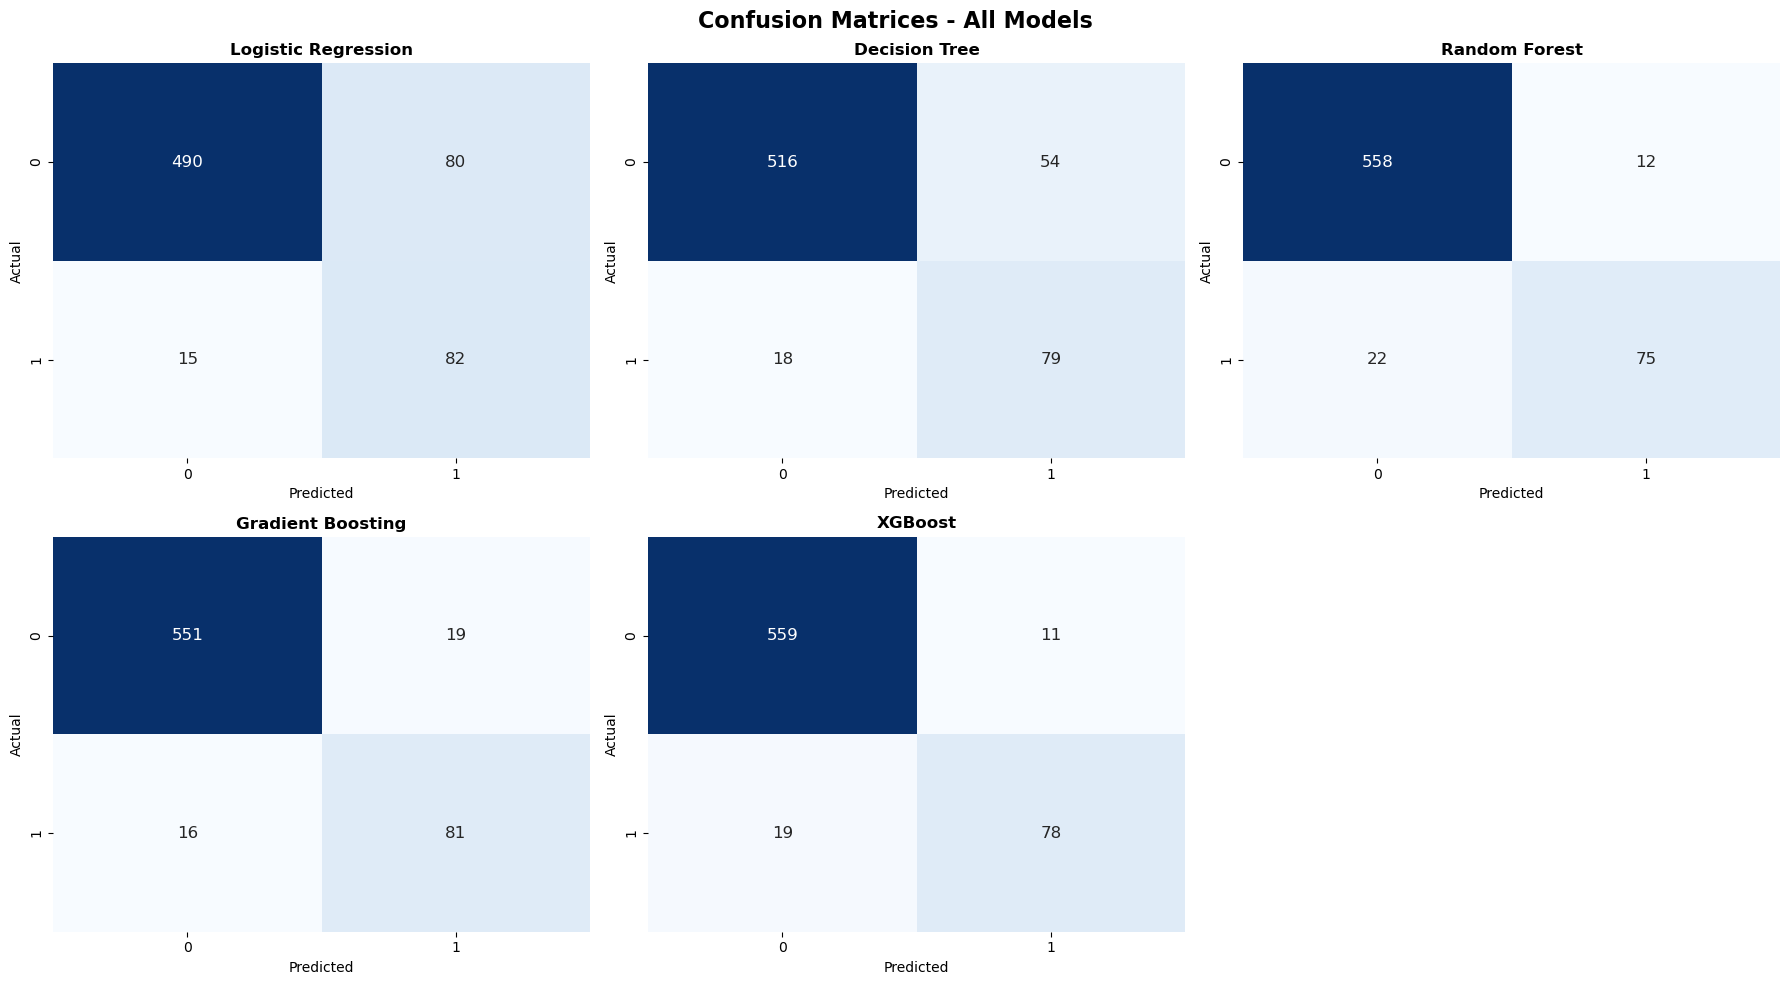

In [89]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Confusion Matrices - All Models', fontsize=16, fontweight='bold')
axes = axes.flatten()

for idx, name in enumerate(models.keys()):
    cm = confusion_matrix(y_test, test_predictions[name]['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], 
                cbar=False, annot_kws={"size": 12})
    axes[idx].set_title(name, fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

# Hide the last subplot if odd number of models
if len(models) < 6:
    axes[-1].axis('off')

plt.tight_layout()
plt.savefig('../visualizations/enhanced/confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

# =============================================================
# ROC CURVES
# =============================================================

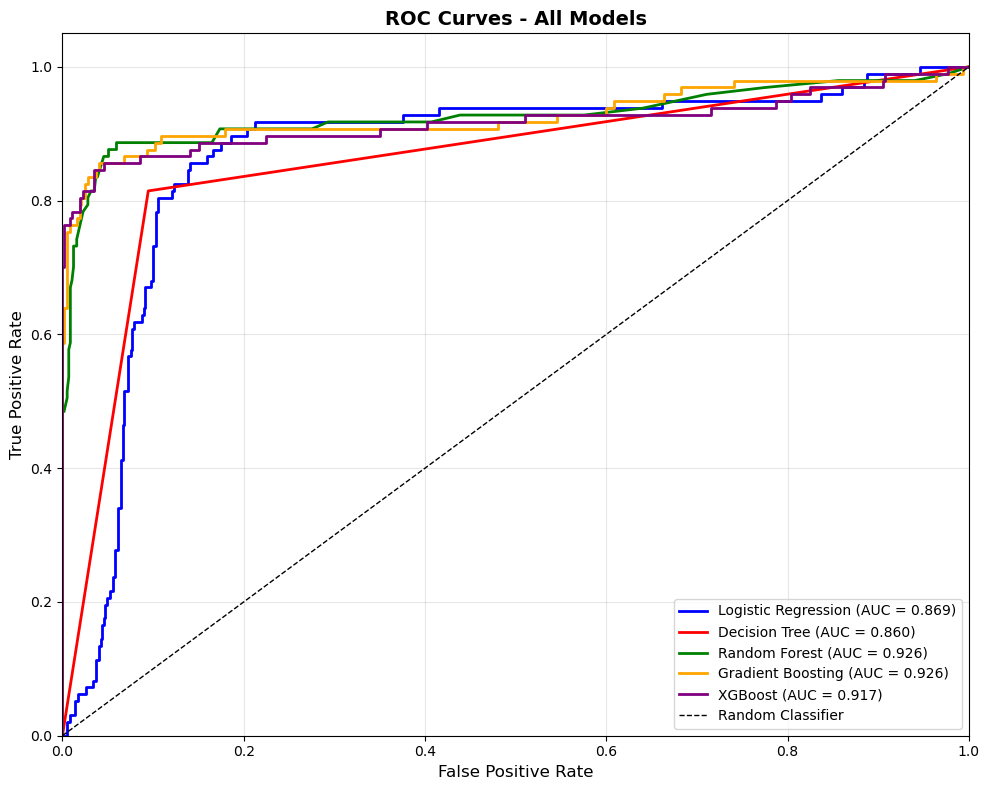

In [90]:
plt.figure(figsize=(10, 8))

colors = ['blue', 'red', 'green', 'orange', 'purple']
for idx, (name, pred_dict) in enumerate(test_predictions.items()):
    fpr, tpr, _ = roc_curve(y_test, pred_dict['y_prob'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})', 
             linewidth=2, color=colors[idx % len(colors)])

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - All Models', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('../visualizations/enhanced/roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()


# =============================================================
# OVERFITTING VISUALIZATION
# =============================================================

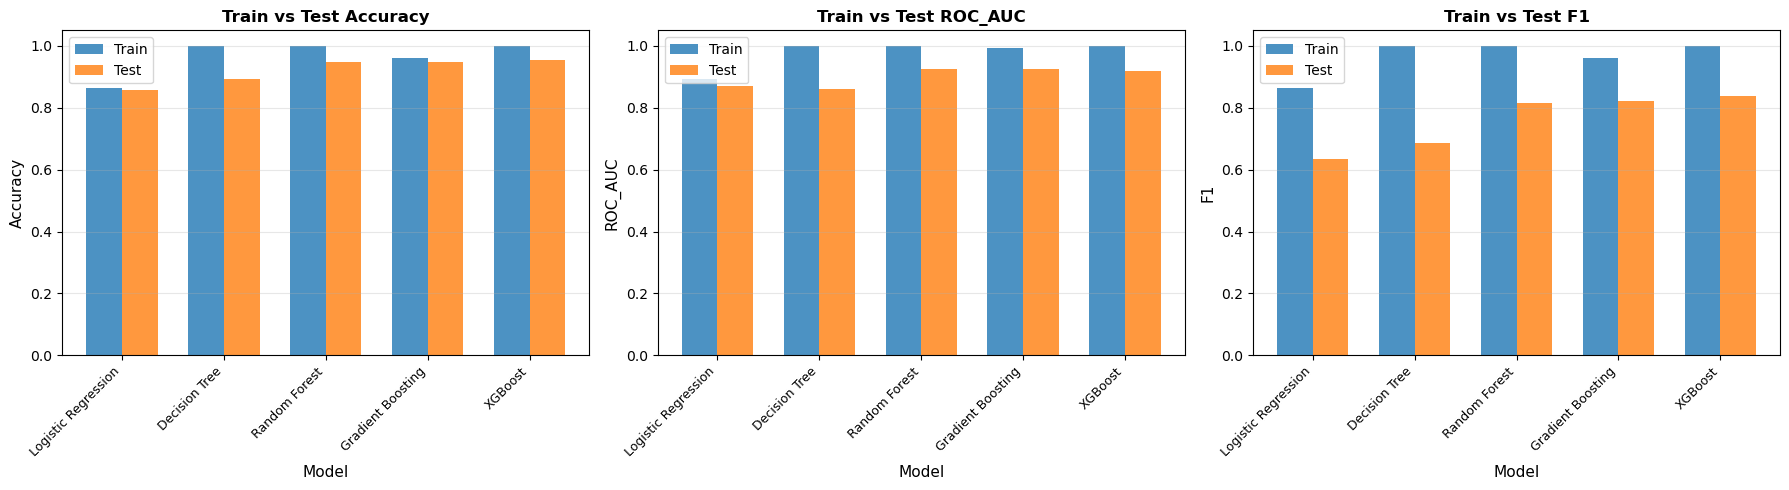

In [91]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['Accuracy', 'ROC_AUC', 'F1']
for idx, metric in enumerate(metrics):
    ax = axes[idx]
    x = np.arange(len(overfitting_df))
    width = 0.35
    
    train_col = f'Train_{metric}'
    test_col = f'Test_{metric}'
    
    ax.bar(x - width/2, overfitting_df[train_col], width, label='Train', alpha=0.8)
    ax.bar(x + width/2, overfitting_df[test_col], width, label='Test', alpha=0.8)
    
    ax.set_xlabel('Model', fontsize=11)
    ax.set_ylabel(metric, fontsize=11)
    ax.set_title(f'Train vs Test {metric}', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(overfitting_df['Model'], rotation=45, ha='right', fontsize=9)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../visualizations/enhanced/overfitting_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


# =============================================================
# BEST MODEL SELECTION AND DETAILED REPORT
# =============================================================

In [92]:
best_model_name = comparison_df.iloc[0]['Model']
best_model = trained_models[best_model_name]

print(f"\nBEST MODEL: {best_model_name}\n")

best_test_results = test_results_df[test_results_df['Model'] == best_model_name].iloc[0]
best_overfitting = overfitting_df[overfitting_df['Model'] == best_model_name].iloc[0]

print("\nTest Set Performance:")
print(f"  Accuracy:  {best_test_results['Test_Accuracy']:.4f}")
print(f"  Precision: {best_test_results['Test_Precision']:.4f}")
print(f"  Recall:    {best_test_results['Test_Recall']:.4f}")
print(f"  F1-Score:  {best_test_results['Test_F1']:.4f}")
print(f"  ROC-AUC:   {best_test_results['Test_ROC_AUC']:.4f}")

print("\nOverfitting Analysis:")
print(f"  Train-Test Accuracy Gap: {best_overfitting['Accuracy_Gap']:.4f}")
print(f"  Train-Test ROC-AUC Gap:  {best_overfitting['ROC_AUC_Gap']:.4f}")
print(f"  Overfitting Risk:        {best_overfitting['Overfitting_Risk']}")

print("\nDetailed Classification Report:")
print(classification_report(y_test, test_predictions[best_model_name]['y_pred']))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, test_predictions[best_model_name]['y_pred'])
print(cm)


BEST MODEL: Random Forest


Test Set Performance:
  Accuracy:  0.9490
  Precision: 0.8621
  Recall:    0.7732
  F1-Score:  0.8152
  ROC-AUC:   0.9258

Overfitting Analysis:
  Train-Test Accuracy Gap: 0.0510
  Train-Test ROC-AUC Gap:  0.0742
  Overfitting Risk:        Moderate

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       570
           1       0.86      0.77      0.82        97

    accuracy                           0.95       667
   macro avg       0.91      0.88      0.89       667
weighted avg       0.95      0.95      0.95       667


Confusion Matrix:
[[558  12]
 [ 22  75]]
